# Some Examples of Fitting Transits
- Fit light curves from TESS
- Quadratic and Non-linear Limb darkening
- Automatically scrape priors from NASA Exoplanet Archive
- Derive robust posteriors using nested sampling

## Generate test data
We'll start with a lightcurve of WASP-43 b from TESS

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk

search_result = lk.search_targetpixelfile("HAT-P-32 b", mission='TESS')
print(search_result)

SearchResult containing 1 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 18 2019 TESS-SPOC    1800   292152376      0.0


In [2]:
from scipy.ndimage import binary_dilation

# download first result
tpf = search_result[0].download(quality_bitmask='hard')

# create a quick light curve
amask = binary_dilation(tpf.pipeline_mask)
lc = tpf.to_lightcurve(aperture_mask=amask)

# run an aper selection routine

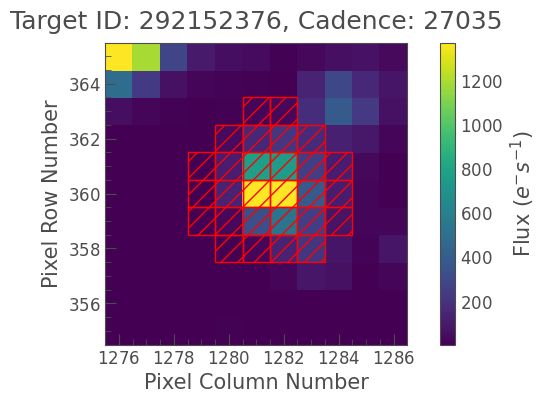

In [3]:
tpf.plot(aperture_mask=amask)
plt.show()

# Clean up the light curve and detrend

Text(0, 0.5, 'Raw Flux')

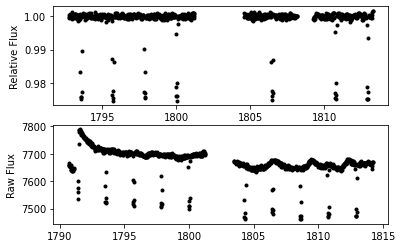

In [4]:
from wotan import flatten

# remove data after gaps
tmask = np.ones(lc.time.shape).astype(bool)
smask = np.argsort(lc.time.value)
dts = np.diff(lc.time.value[smask])
dmask = dts > (1./24)     # find gaps bigger than an hour
ndt = int(1.0/dts.mean()) # number of images in a day
tmask[0:int(ndt)*2] = False # mask first day of sequence

# mask data after gaps due to systematics
for idx in np.argwhere(dmask).flatten(): 
    tmask[idx:idx+int(ndt)] = False

# truncate arrays
nmask = ~np.isnan(lc.flux.value)
time = lc.time.value[tmask&nmask]
flux = lc.flux.value[tmask&nmask]
ferr = lc.flux.value[tmask&nmask]**0.5

# remove stellar variability
dflux, ftrend = flatten( time, flux,
    window_length=0.5, return_trend=True, method='biweight')
dferr = ferr/ftrend

fig, ax = plt.subplots(2)
ax[0].plot(time, dflux, 'k.')
ax[0].set_ylabel("Relative Flux")

ax[1].plot(lc.time.value, lc.flux.value, 'k.')
ax[1].set_ylabel("Raw Flux")

# Run a transit periodogram to get an ephemeris estimate

In [5]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(time, dflux)
results = model.power()

print('Period', format(results.period, '.5f'), 'd')
print(len(results.transit_times), 'transit times in time series:', \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Transit depth', format(results.depth, '.5f'))
print('Best duration (days)', format(results.duration, '.5f'))
print('Signal detection efficiency (SDE):', results.SDE)

  0%|          | 0/1775 periods | 00:00<?

Transit Least Squares TLS 1.0.25 (04 June 2020)
Creating model cache for 36 durations
Searching 773 data points, 1775 periods from 0.601 to 10.281 days
Using all 16 CPU threads


100%|██████████| 1775/1775 periods | 00:05<00:00 


Period 2.14897 d
10 transit times in time series: ['1793.57304', '1795.72201', '1797.87099', '1800.01996', '1802.16893', '1804.31791', '1806.46688', '1808.61586', '1810.76483', '1812.91380']
Transit depth 0.97490
Best duration (days) 0.08586
Signal detection efficiency (SDE): 35.93330772479382


# Query the NASA Exoplanet Archive for priors
Priors come from the pscompars table. 
https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html

In [6]:
from elca.tools import nea_scrape

nea_df = nea_scrape("HAT-P-32 b")
prior = {} # convert to dict
for key in nea_df.keys():
    prior[key] = nea_df[key][0]

https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,hostname,pl_radj,pl_radjerr1,ra,dec,pl_ratdor,pl_ratdorerr1,pl_ratdorerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbeccen,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orblper,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,st_teff,st_tefferr1,st_tefferr2,st_met,st_meterr1,st_meterr2,st_logg,st_loggerr1,st_loggerr2,st_mass,st_rad,st_raderr1+from+pscomppars+where+tran_flag+=+1+and+pl_name+=+'HAT-P-32+b'+&format=csv


In [7]:
nea_df

,pl_name,hostname,pl_radj,pl_radjerr1,ra,dec,pl_ratdor,pl_ratdorerr1,pl_ratdorerr2,pl_orbincl,...,st_tefferr2,st_met,st_meterr1,st_meterr2,st_logg,st_loggerr1,st_loggerr2,st_mass,st_rad,st_raderr1
0,HAT-P-32 b,HAT-P-32,1.98,0.045,31.042761,46.687851,5.344,0.04,-0.039,88.98,...,-88.0,-0.16,0.08,-0.08,4.22,0.04,-0.04,1.13,1.37,0.03


In [8]:
nea_df.keys()

Index(['pl_name', 'hostname', 'pl_radj', 'pl_radjerr1', 'ra', 'dec',
       'pl_ratdor', 'pl_ratdorerr1', 'pl_ratdorerr2', 'pl_orbincl',
       'pl_orbinclerr1', 'pl_orbinclerr2', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbeccen', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orblper', 'pl_tranmid', 'pl_tranmiderr1',
       'pl_tranmiderr2', 'pl_ratror', 'pl_ratrorerr1', 'pl_ratrorerr2',
       'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_met', 'st_meterr1',
       'st_meterr2', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_mass',
       'st_rad', 'st_raderr1'],
      dtype='object')

# Create limb darkening coefficients

In [9]:
from ldtk import LDPSetCreator, BoxcarFilter
from ldtk.filters import create_tess

tessfilter = create_tess()
sc = LDPSetCreator(
    teff=(prior['st_teff'],  prior['st_tefferr1']),    # Define your star, and the code
    logg=(prior['st_logg'],  prior['st_loggerr1']),    # downloads the uncached stellar
    z=(prior['st_met'], prior['st_meterr1']),    # spectra from the Husser et al.
    filters=[tessfilter])                        # FTP server automatically.
 
ps = sc.create_profiles()          # Create the limb darkening profiles
cq,eq = ps.coeffs_qd(do_mc=False)  # Estimate quadratic law coefficients
u1,u2 = cq[0][0], cq[0][1]

# Fit the data using a Mandel and Agol transit and nested sampling
https://johannesbuchner.github.io/UltraNest/index.html

In [10]:
from astropy import units as u
from elca.tools import lc_fitter

# annoying conversion
rprs = (prior['pl_radj']*u.R_jup/(prior['st_rad']*u.R_sun)).to(u.km/u.km).value
print(rprs)

# set up the priors, bounds and fit the light curve
lcprior = { 
    'rprs':rprs, # Rp/Rs
    'ars': prior['pl_ratdor'],    # a/Rs
    'per': prior['pl_orbper'],    # Period [day]
    'inc': prior['pl_orbincl'],   # Inclination [deg]
    'u1': u1, 'u2': u2,  # limb darkening (linear, quadratic)
    'ecc': prior['pl_orbeccen'],  # Eccentricity
    'omega': prior['pl_orblper'], # Arg of periastron
    'tmid': float(results.transit_times[0]) 
    # use oldest time of mid transit [day]
}
print(lcprior)

mybounds = {
    'rprs':[0,2*rprs],
    'per':[float(results.period)*0.99,
           float(results.period)*1.01],
    'tmid':[lcprior['tmid']-0.02,
            lcprior['tmid']+0.02],
    'ars':[prior['pl_ratdor']-20*prior['pl_ratdorerr1'],
           prior['pl_ratdor']+20*prior['pl_ratdorerr1']],
}

phase = abs((time - lcprior['tmid'] + 0.25*lcprior['per'])/lcprior['per']) %1 - 0.25

pmask = (phase > -0.1) & (phase < 0.1)
myfit = lc_fitter(time[pmask], dflux[pmask], dferr[pmask], lcprior, mybounds, verbose=True)

0.14851833316021565
{'rprs': 0.14851833316021565, 'ars': 5.344, 'per': 2.1500082, 'inc': 88.98, 'u1': 0.384774240328551, 'u2': 0.1469198632433824, 'ecc': 0.159, 'omega': 50.0, 'tmid': 1793.5730400571383}
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1  29 [-1.5455..-1.5450]*| it/evals=5400/14491 eff=38.3223% N=400   
[ultranest] Likelihood function evaluations: 14604
[ultranest]   logZ = -10.47 +- 0.09048
[ultranest] Effective samples strategy satisfied (ESS = 2224.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.24, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.


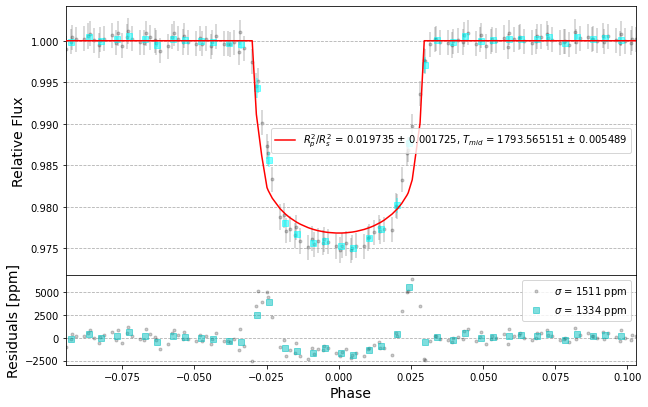

In [11]:
myfit.plot_bestfit(phase=True)
plt.show()

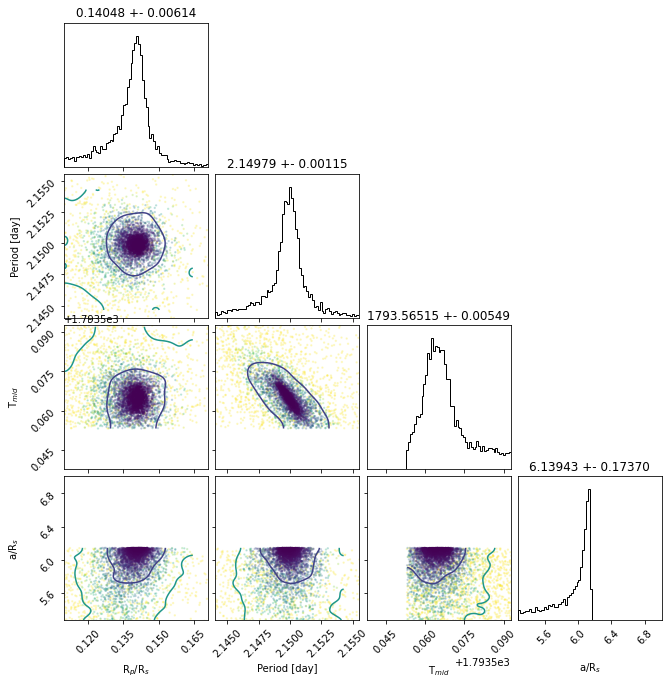

In [12]:
myfit.plot_triangle()
plt.show()

# Fit the data with Non-linear Limb Darkening

In [13]:
from elca.tools import lc_fitter_detrend
from exotic.exotic import LimbDarkening

ld_obj = LimbDarkening(
    teff=prior['st_teff'], teffpos=prior['st_tefferr1'], teffneg=prior['st_tefferr1'],
    met=prior['st_met'], metpos=prior['st_meterr1'], metneg=prior['st_meterr1'],
    logg=prior['st_logg'], loggpos=prior['st_loggerr1'], loggneg=prior['st_loggerr1'],
    wl_min=tessfilter.wl.min(), wl_max=tessfilter.wl.max(), filter_type="Clear")

ld0, ld1, ld2, ld3, filt, wlmin, wlmax = ld_obj.nonlinear_ld()
ld = [ld0[0], ld1[0], ld2[0], ld3[0]]

# set up the priors, bounds and fit the light curve
lcprior = { 
    'rprs':rprs, # Rp/Rs
    'ars': prior['pl_ratdor'],    # a/Rs
    'per': prior['pl_orbper'],    # Period [day]
    'inc': prior['pl_orbincl'],   # Inclination [deg]
    'u0': ld[0], 'u1': ld[1],     # limb darkening
    'u2': ld[2], 'u3': ld[3],
    'ecc': prior['pl_orbeccen'],  # Eccentricity
    'omega': prior['pl_orblper'], # Arg of periastron
    'tmid': float(results.transit_times[0]),   
    # time of mid transit [day]

    # ignore airmass trend: a1*np.exp(a2*airmass)
    'a1':1,
    'a2':0,
}


mybounds = {
    'rprs':[0,2*rprs],
    'per':[float(results.period)*0.99,
           float(results.period)*1.01],
    'tmid':[lcprior['tmid']-0.01,
            lcprior['tmid']+0.01],
    'ars':[prior['pl_ratdor']-20*prior['pl_ratdorerr1'],
           prior['pl_ratdor']+20*prior['pl_ratdorerr1']],
}


# fake airmass, we're ignoring it above but exotic wants it
airmass = np.ones(len(time))

myfit_nl = lc_fitter_detrend(time[pmask], dflux[pmask], 
                          dferr[pmask], airmass[pmask], 
                          lcprior, mybounds, verbose=True)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-0.3  [-0.4277..-0.4276]*| it/evals=4920/12428 eff=40.9046% N=400 0  
[ultranest] Likelihood function evaluations: 12428
[ultranest]   logZ = -8.092 +- 0.08497
[ultranest] Effective samples strategy satisfied (ESS = 2099.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.08 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.


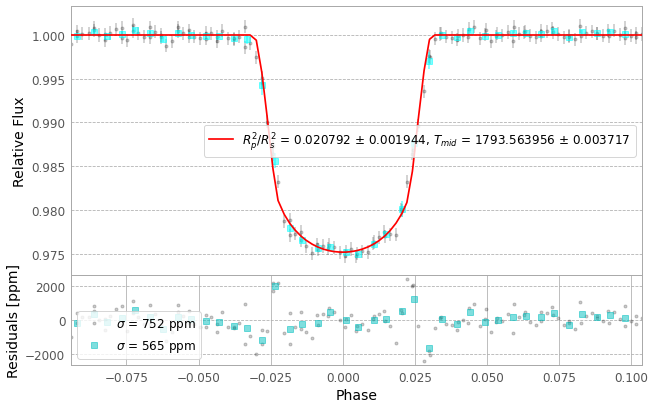

In [14]:
myfit_nl.plot_bestfit()
plt.show()

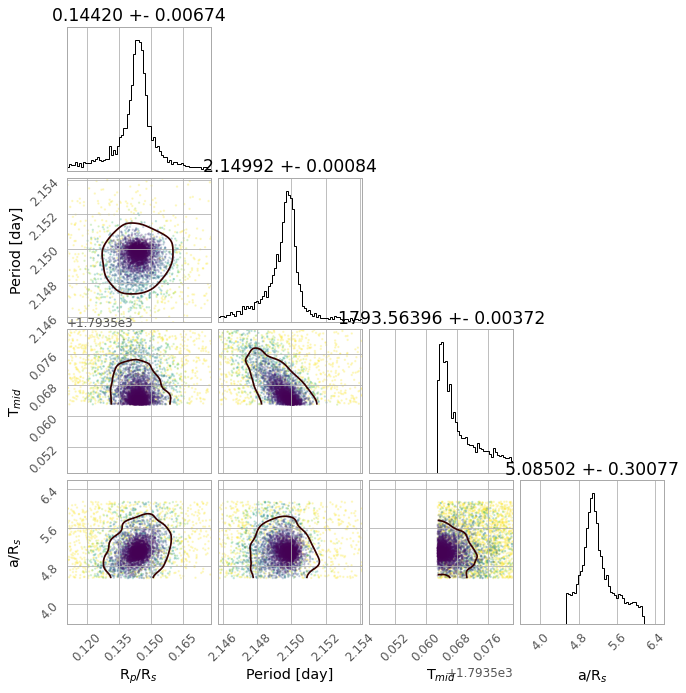

In [15]:
myfit_nl.plot_triangle()
plt.show()
# exotic does weird stuff with the plot styles

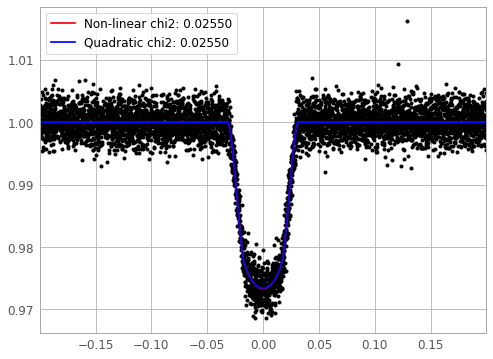

In [16]:
# compare transit models
phase = ((exoticfit.time - exoticfit.parameters['tmid'] + 0.25*exoticfit.parameters['per'] )/ exoticfit.parameters['per'] %1) - 0.25
si = np.argsort(phase)
plt.plot(phase, exoticfit.data, 'k.')
plt.plot(phase[si], exoticfit.transit[si], 'r-',label=f'Non-linear chi2: {exoticfit.chi2/len(exoticfit.time):.5f}')

si = np.argsort(myfit.phase)
plt.plot(myfit.phase[si], myfit.transit[si], 'b-',label=f'Quadratic chi2: {exoticfit.chi2/len(exoticfit.time):.5f}')
plt.xlim(min(phase),max(phase))
plt.legend(loc='best')

# Compare transit models (quadratic LD vs non-linear)

rprs    Quadratic 0.157468 +- 0.002058
     Non-Linear 0.157724 +- 0.002091

per    Quadratic 0.813467 +- 0.000036
     Non-Linear 0.813468 +- 0.000037

tmid    Quadratic 1545.230607 +- 0.000608
     Non-Linear 1545.230634 +- 0.000603

ars    Quadratic 4.979102 +- 0.056526
     Non-Linear 4.975039 +- 0.056371



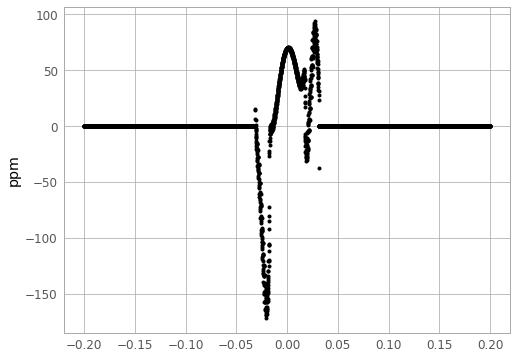

In [17]:
from elca.tools import transit

pmask = (myfit.phase > -0.2) & (myfit.phase < 0.2)

tmodel = transit(time[pmask], myfit.parameters)

plt.plot(phase, 1e6*(tmodel - exoticfit.transit),'k.')
plt.ylabel("ppm")

for k in myfit.bounds.keys():
    print("{}    Quadratic {:.6f} +- {:.6f}".format( k,myfit.parameters[k], myfit.errors[k]))
    print("     Non-Linear {:.6f} +- {:.6f}\n".format( exoticfit.parameters[k], exoticfit.errors[k]))
    